# MSAS RPT Synthetic Demo: SOH@EFC600 + Knee<=600

This notebook demonstrates a **synthetic demo** using three MSAS cells as stand-ins for RPT-style data.
We compare multiple models on two targets:
- **SOH@EFC600** (capacity retention at 600 EFC)
- **knee_before_600** (whether a knee occurs at or before 600 EFC)

Prereqs:
- `data/processed/MSAS` exists (run MSAS preprocessing first).
- `batteryml` is importable.
- `xgboost` is installed for the XGBoost model.

Note: We select three cells from the MSAS **test split** and treat them as synthetic examples for demo purposes.

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import batteryml
from batteryml.pipeline import Pipeline, load_config, build_dataset

In [2]:
try:
    import xgboost  # noqa: F401
except ImportError as exc:
    raise ImportError("xgboost is required for the XGBoost model. Install it first.") from exc

In [3]:
def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "batteryml").exists() and (p / "configs").exists():
            return p
    return start

env_root = os.environ.get("BATTERYML_REPO_ROOT")
if env_root:
    repo_root = Path(env_root)
else:
    repo_root = find_repo_root(Path.cwd())
    if not (repo_root / "configs").exists():
        pkg_root = Path(batteryml.__file__).resolve().parents[1]
        repo_root = find_repo_root(pkg_root)

os.chdir(repo_root)
processed_dir = repo_root / "data/processed/MSAS"
if not processed_dir.exists():
    raise FileNotFoundError("Missing data/processed/MSAS. Run MSAS preprocessing first.")

## 1) Select three cells for the synthetic demo

In [4]:
soh_config_path = repo_root / "configs/soh/transfer/msas_soh_efc600_efcnorm_ridge.yaml"
knee_config_path = repo_root / "configs/soh/transfer/msas_knee_before_600_efcnorm_ridge.yaml"
select_workspace = repo_root / "workspaces/msas/_synthetic_select"

soh_cfg = load_config(str(soh_config_path), str(select_workspace))
_, soh_raw = build_dataset(soh_cfg, device="cpu")
soh_test_ids = {c.cell_id for c in soh_raw["test_cells"]}

knee_cfg = load_config(str(knee_config_path), str(select_workspace))
_, knee_raw = build_dataset(knee_cfg, device="cpu")
knee_test_ids = {c.cell_id for c in knee_raw["test_cells"]}

shared_ids = sorted(soh_test_ids & knee_test_ids)
if len(shared_ids) < 3:
    raise ValueError("Need at least 3 shared test cells between SOH and knee tasks.")
selected_cell_ids = shared_ids[:3]
print("selected_cell_ids:", selected_cell_ids)

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\_synthetic_select
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.
selected_cell_ids: ['MSAS_S1_TP_z01_01', 'MSAS_S1_TP_z02_03', 'MSAS_S1_TP_z05_03']


## 2) Helpers for per-cell predictions

In [5]:
def _index_map(cells):
    return {c.cell_id: i for i, c in enumerate(cells)}

def predict_regression(config_map, selected_ids, task_name, force_rerun=True):
    rows = []
    for model_name, rel_path in config_map.items():
        config_path = repo_root / rel_path
        workspace = repo_root / f"workspaces/msas/synthetic_demo/{task_name}/{model_name.lower()}"
        pipe = Pipeline(config_path=str(config_path), workspace=str(workspace))
        model, dataset = pipe.train(skip_if_executed=not force_rerun)
        prediction = model.predict(dataset).detach().cpu().numpy().reshape(-1)
        y_true = dataset.test_data.label.detach().cpu().numpy().reshape(-1)
        test_cells = pipe.raw_data["test_cells"]
        id_to_idx = _index_map(test_cells)

        for cid in selected_ids:
            idx = id_to_idx.get(cid)
            if idx is None:
                continue
            rows.append({
                "cell_id": cid,
                "model": model_name,
                "y_true": float(y_true[idx]),
                "y_pred": float(prediction[idx]),
            })
    return pd.DataFrame(rows)

def predict_binary(config_map, selected_ids, task_name, threshold=0.5, force_rerun=True):
    rows = []
    for model_name, rel_path in config_map.items():
        config_path = repo_root / rel_path
        workspace = repo_root / f"workspaces/msas/synthetic_demo/{task_name}/{model_name.lower()}"
        pipe = Pipeline(config_path=str(config_path), workspace=str(workspace))
        model, dataset = pipe.train(skip_if_executed=not force_rerun)
        prediction = model.predict(dataset).detach().cpu().numpy().reshape(-1)
        y_true = dataset.test_data.label.detach().cpu().numpy().reshape(-1)
        test_cells = pipe.raw_data["test_cells"]
        id_to_idx = _index_map(test_cells)

        for cid in selected_ids:
            idx = id_to_idx.get(cid)
            if idx is None:
                continue
            prob = float(prediction[idx])
            rows.append({
                "cell_id": cid,
                "model": model_name,
                "y_true": int(y_true[idx]),
                "pred_prob": prob,
                "pred_label": int(prob >= threshold),
            })
    return pd.DataFrame(rows)

## 3) SOH@EFC600 (capacity retention)

In [6]:
soh_config_map = {
    "Ridge": "configs/soh/transfer/msas_soh_efc600_efcnorm_ridge.yaml",
    "XGBoost": "configs/soh/transfer/msas_soh_efc600_efcnorm_xgb.yaml",
    "RandomForest": "configs/soh/transfer/msas_soh_efc600_efcnorm_rf.yaml",
}

soh_long = predict_regression(soh_config_map, selected_cell_ids, task_name="soh_efc600")
soh_true = soh_long.drop_duplicates("cell_id")[["cell_id", "y_true"]]
soh_pred = soh_long.pivot_table(index="cell_id", columns="model", values="y_pred")
soh_table = soh_true.merge(soh_pred, on="cell_id")
soh_table

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\soh_efc600\ridge
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\soh_efc600\xgboost
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\soh_efc600\randomforest
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.


,cell_id,y_true,RandomForest,Ridge,XGBoost
0,MSAS_S1_TP_z01_01,0.900065,0.836316,0.625910,0.753850
1,MSAS_S1_TP_z02_03,0.720891,0.786286,0.780797,0.782452
2,MSAS_S1_TP_z05_03,1.349499,1.226350,1.198528,1.184068


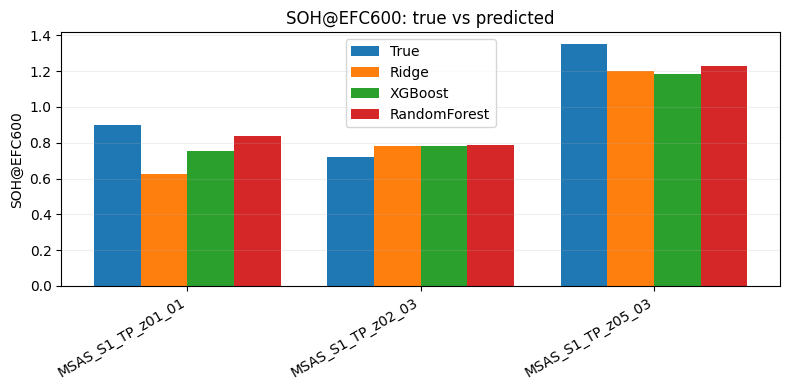

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(soh_table))
width = 0.2

ax.bar(x - 1.5 * width, soh_table["y_true"], width, label="True")
for i, model_name in enumerate(["Ridge", "XGBoost", "RandomForest"]):
    ax.bar(x + (i - 0.5) * width, soh_table[model_name], width, label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(soh_table["cell_id"], rotation=30, ha="right")
ax.set_ylabel("SOH@EFC600")
ax.set_title("SOH@EFC600: true vs predicted")
ax.grid(True, axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()

## 4) Knee-before-600 (binary)

In [8]:
knee_config_map = {
    "Ridge": "configs/soh/transfer/msas_knee_before_600_efcnorm_ridge.yaml",
    "XGBoost": "configs/soh/transfer/msas_knee_before_600_efcnorm_xgb.yaml",
    "RandomForest": "configs/soh/transfer/msas_knee_before_600_efcnorm_rf.yaml",
}

knee_long = predict_binary(knee_config_map, selected_cell_ids, task_name="knee_before_600")
knee_true = knee_long.drop_duplicates("cell_id")[["cell_id", "y_true"]]
knee_prob = knee_long.pivot_table(index="cell_id", columns="model", values="pred_prob")
knee_label = knee_long.pivot_table(index="cell_id", columns="model", values="pred_label")

knee_prob_table = knee_true.merge(knee_prob, on="cell_id")
knee_label_table = knee_true.merge(knee_label, on="cell_id")

knee_prob_table

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\knee_before_600\ridge
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\knee_before_600\xgboost
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\synthetic_demo\knee_before_600\randomforest
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.


KeyError: "None of [Index(['cell_id', 'y_true'], dtype='str')] are in the [columns]"

In [ ]:
knee_label_table

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(knee_prob_table))
width = 0.2

ax.bar(x - 1.5 * width, knee_prob_table["y_true"], width, label="True label")
for i, model_name in enumerate(["Ridge", "XGBoost", "RandomForest"]):
    ax.bar(x + (i - 0.5) * width, knee_prob_table[model_name], width, label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(knee_prob_table["cell_id"], rotation=30, ha="right")
ax.set_ylabel("Predicted probability")
ax.set_title("Knee<=600: predicted probabilities")
ax.grid(True, axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()